# Мобильное приложение по продаже продуктов питания

В рамках исследования нужно разобраться, как ведут себя пользователи мобильного приложения стартапа, который продаёт продукты питания. Необходимо:
1. Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

2. Исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одна экспериментальная — с новыми. Нужно выяснить, какой шрифт лучше.

**Оглавление:**
1. [Предобработка данных](#1)
2. [Изучение и проверка данных](#2)
3. [Изучение воронки событий](#3)
4. [Изучение результатов A/A/B-эксперимента](#4)
5. [Общий вывод](#5)

<a id="1"></a>
##  Предобработка данных

**1.1** Для начала загрузим все необходимые библиотеки. 

In [1]:
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth
from plotly import graph_objects as go

**1.2** Теперь загрузим данные и изучим общую информацию. 

In [3]:
events = pd.read_csv('datasets/logs_exp.csv', sep='\t')
events.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [4]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**1.3** Датафрейм имеет 244 126 строк и 4 столбца:
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Из данных сразу видно, что таблица не имеет пропусков. 

**1.4** Для начала переведём названия столбцов в предпочтительный вид. 

In [5]:
events.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']

**1.5** Теперь проверим, есть ли в таблице явные дубликаты.

In [7]:
print(events.duplicated().sum())

413


**1.6** В таблице содержится 413 явных дубликатов. Учитывая содержание колонок (уникальные id события и пользователя, а также время события), можно сделать вывод, что это случайные дубликаты, от которых можно избавиться. К тому же они занимают очень маленькую часть от общих данных.

In [8]:
events = events.drop_duplicates().reset_index(drop=True)

**1.7** Теперь создадим по столбцу `event_timestamp` столбец даты и времени, а также отдельный столбец дат.

In [9]:
events['event_datetime'] = pd.to_datetime(events['event_timestamp'], unit='s')
events['event_date'] = pd.to_datetime(events['event_datetime'], format='%Y-%m-%d').dt.date

In [10]:
events.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [11]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   event_datetime   243713 non-null  datetime64[ns]
 5   event_date       243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


**1.8** Так как в процессе исследования нам нужно будет анализировать результаты A/A/B-теста, также необходимо проверить, чтобы пользователи всех 3 групп были уникальны. Для этого сгруппируем датафрейм по идентификатору пользователя и найдём кол-во уникальных групп для каждого клиента.

In [12]:
not_unique_users = events.groupby('device_id_hash')['exp_id'].nunique().reset_index().query('exp_id > 1').count()
print('Количество пользователей, находящихся в разных группах:', not_unique_users['exp_id'])

Количество пользователей, находящихся в разных группах: 0


**1.9** Пользователи во всех группах уникальные. 

**Вывод по 1-му пункту:**

После предобработки данных:
- Было выявлено и удалено 413 дубликатов. 
- Были созданы необходимые для анализа столбцы с датами нужного типа.
- Названия столбцов были переведены к привычному типу.
- Было выявлено, что в таблице нет пропусков.

<a id="2"></a>
##  Изучение и проверка данных

**2.1** Проверим, сколько всего событий в логе. Для этого сгруппируем данные по названию события и посчитаем количество логов в каждом из них.

In [15]:
print('Всего событий в логе:', events['event_timestamp'].count())
events.groupby('event_name').agg({'event_timestamp':'count'}).sort_values(by='event_timestamp', ascending=False)

Всего событий в логе: 243713


,event_timestamp
event_name,
MainScreenAppear,119101
OffersScreenAppear,46808
CartScreenAppear,42668
PaymentScreenSuccessful,34118
Tutorial,1018


**2.2** Мы видим, что всего в логе 243 713 событий, что соответствует кол-ву строк, и распределены они неравномерно. Так, например, событие `MainScreenAppear` совершили 119 101 пользователь, а событие `Tutorial` — всего 1 018 пользователей.

**2.3** Теперь посмотрим, сколько всего уникальных пользователей в логе.

In [16]:
events['device_id_hash'].nunique()

7551

**2.4** Всего в логе 7 551 пользователь. 

**2.5** Проверим, сколько в среднем событий приходится на пользователя. Для начала нужно посмотреть, нет ли в данных выбросов. Найдём количество событий на каждого пользователя и применим метод `describe()`.

In [17]:
events.groupby('device_id_hash').agg({'event_timestamp':'count'}).describe()

,event_timestamp
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


**2.6** Мы видим, что 75% пользователей совершало до 37 событий. При этом в данных явно есть аномальные значения: так, максимум на клиента приходилось 2 307 событий. Поэтому правильным будет взять не среднее значение событий на пользователя, а медиану. 

Таким образом, в среднем на пользователя за исследуемый период приходилось 20 событий. 

**2.7** Посмотрим, данными за какой период мы располагаем. 

In [18]:
print('Минимальная дата:', events['event_date'].min())
print('Максимальная дата:', events['event_date'].max())

Минимальная дата: 2019-07-25
Максимальная дата: 2019-08-07


**2.8** Итак, у нас есть данные за период с 25 июля по 7 августа 2019 года. Проверим, как меняется количество данных в зависимости от времени: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп.

Для начала создадим сводную таблицу, где индексами выступят даты, а столбцами — группы эксперимента. 

In [19]:
pivot_event_count = events.pivot_table(index='event_date', columns='exp_id', values='event_name', aggfunc='count')
pivot_event_count

exp_id,246,247,248
event_date,,,
2019-07-25,4,1,4
2019-07-26,14,8,9
2019-07-27,24,23,8
2019-07-28,33,36,36
2019-07-29,55,58,71
2019-07-30,129,138,145
2019-07-31,620,664,746
2019-08-01,11561,12306,12274
2019-08-02,10946,10990,13618


**2.9** Теперь построим график. 

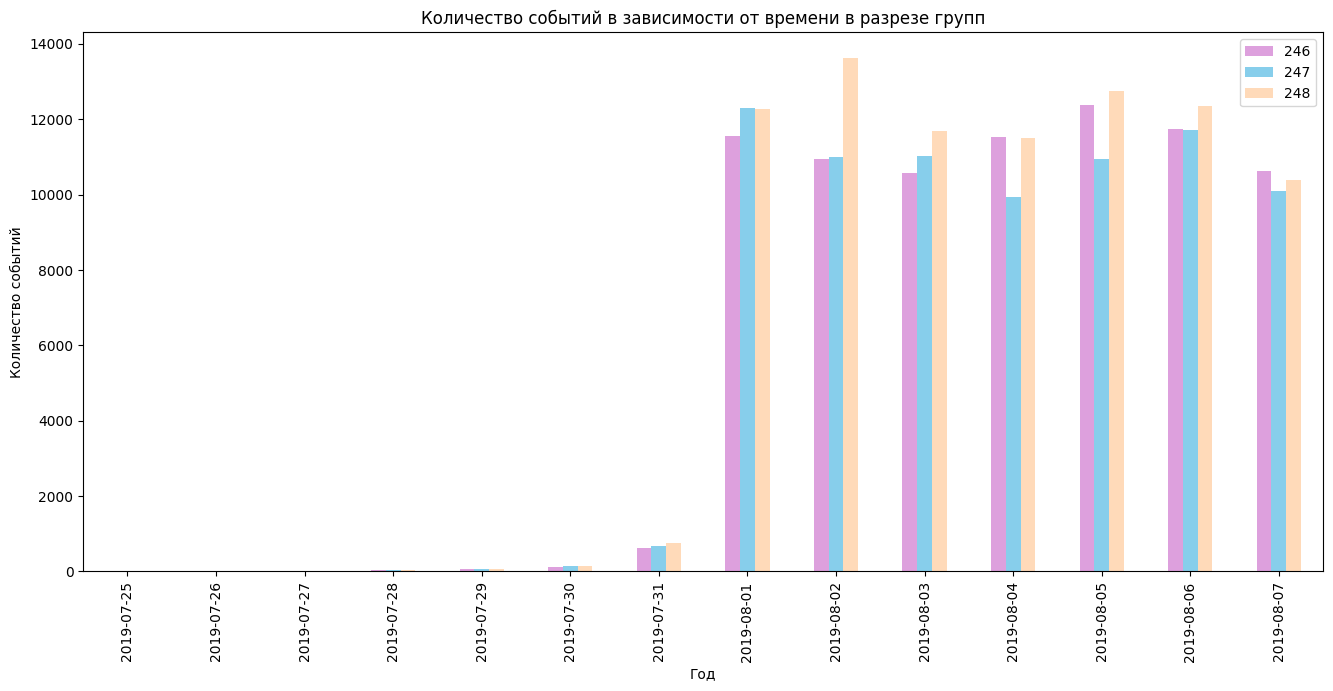

In [20]:
colors = {246: 'plum', 247: 'skyblue', 248: 'peachpuff'}

pivot_event_count.plot(kind='bar', figsize=(16,7), color = colors)
plt.title('Количество событий в зависимости от времени в разрезе групп')
plt.xlabel('Год')
plt.ylabel('Количество событий')
plt.legend()
plt.show()

**2.10** Мы видим, что основная часть данных находится в периоде с 1 по 7 августа 2019 года. По сравнению с этим периодом данные за июль выглядят неполными. Проверим, сколько всего данных представлено за июль, и сравним этот показатель с первым днём августа, чтобы понять, какой процент от всего лишь одного дня августа занимают данные за июль.

In [21]:
events_july = events[(events['event_date'].astype(str) <= '2019-07-31')]
print('Количество логов с 25 по 31 июля:', events_july['event_date'].count())

Количество логов с 25 по 31 июля: 2826


In [22]:
events_august = events[(events['event_date'].astype(str) == '2019-08-01')]
print('Количество логов за 1 августа:', events_august['event_date'].count())

Количество логов за 1 августа: 36141


In [23]:
print('Доля данных за последнюю неделю июля по отношению к 1 августа:', 
      "{0:.2%}".format(events_july['event_date'].count() / events_august['event_date'].count()))

Доля данных за последнюю неделю июля по отношению к 1 августа: 7.82%


**2.11** За последнюю неделю июля собрано всего 2 826, и это 7,82% от первого дня августа (нужно учитывать, что в каждый день августа собрано намного больше данных, чем за весь исследуемый июльский период). Значит, можно сделать вывод, что данные за июль неполные. Следовательно, их можно отбросить, оставив данные только за период с 1 по 7 августа. 

In [24]:
actual_events = events[(events['event_date'].astype(str) > '2019-07-31')]
actual_events.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


**2.12** Проверим, правильно ли мы отфильтровали датафрейм.

In [25]:
print('Минимальная дата:', actual_events['event_date'].min())
print('Максимальная дата:', actual_events['event_date'].max())

Минимальная дата: 2019-08-01
Максимальная дата: 2019-08-07


**2.13** Проверим, много ли событий и пользователей мы потеряли, отбросив старые данные.

In [26]:
print('Количество потерянных событий:', events['event_timestamp'].count() - actual_events['event_timestamp'].count())

print('Доля потерянных событий:', 
      "{0:.2%}".format(1 - actual_events['event_timestamp'].count() / events['event_timestamp'].count()))

print('Количество потерянных пользователей:', events['device_id_hash'].nunique() - actual_events['device_id_hash'].nunique())

print('Доля потерянных пользователей:', 
      "{0:.2%}".format(1 - actual_events['device_id_hash'].nunique() / events['device_id_hash'].nunique()))


Количество потерянных событий: 2826
Доля потерянных событий: 1.16%
Количество потерянных пользователей: 17
Доля потерянных пользователей: 0.23%


**2.14** При срезе таблицы мы потеряли 2 826 событий из 243 713 (1.16%) и всего лишь 17 пользователей (0.23%). Это незначительные данные. 

**2.15** Теперь проверим, что у нас в очищенных данных есть пользователи из всех трёх экспериментальных групп.

In [27]:
actual_events.groupby('exp_id').agg({'device_id_hash':'nunique'})

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


**2.16** Пользователи остались во всех трёх группах, при этом распределены они достаточно равномерно.

**Выводы на 2-му пункту:**

В рамках изучения и проверки данных была проведена следующая работа:
- Выявлено, что в исходном датафрейме есть данные о 243 713 событиях и 7 551 пользователях. При этом количество событий по каждому из типу распределено неравномерно. 
- Опредено, что в среднем на пользователя приходится 20 событий.
- Изучено, что изначально мы располагаем данными за период с 25 июля по 7 августа. В связи с неполными данными за конец июля, было принято решение оставить только записи за период с 1 по 7 августа.
- Проверено, что в ходе среза данных мы потеряли записи о 2 826 событиях (1.16%) и всего лишь о 17 пользователях (0.23%), что является незначительным.
- Проверено, что в очищенных данных остались пользователи из всех трёх экспериментальных групп, которые распределены достаточно равномерно. 

<a id="3"></a>
##  Изучение воронки событий

**3.1** Посмотрим, какие события есть в логах и как часто они встречаются.

In [28]:
actual_events.groupby('event_name').agg({'event_timestamp': 'count'}).sort_values(by='event_timestamp', ascending=False)

,event_timestamp
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


**3.2** В логе содержатся всего 5 типов событий:
- `MainScreenAppear` — переход пользователя на главный экран. 
- `OffersScreenAppear` — переход пользователя в раздел товаров. 
- `CartScreenAppear` — переход пользователя в корзину. 
- `PaymentScreenSuccessful` — успешная оплата товаров пользователем. 
- `Tutorial` — просмотр пользователем руководства по использованию приложения. 

Первые 4 события, по логике, следуют один за другим: сначала пользователь попадает на главный экран, затем переходит в раздел с товарами, затем попадает в корзину, после чего оплачивает заказ. Последовательность событий подтвержает и их количество: обычно чем дальше шаг, тем меньше на него переходят.

Событие `Tutorial` вызывает сомнения. Скорее всего, это доп. раздел, в который пользователь может перейти для ознакомления с функциями приложения. В данном случае этим разделом воспользовались всего 1 005 пользователей за первую неделю августа. 

**3.3** Посчитаем, сколько пользователей совершали каждое из этих событий, а также их долю от общего количества пользователей. Отсортируем события по числу пользователей.

In [29]:
users_in_event = actual_events.groupby('event_name').agg({'device_id_hash': 'nunique'})\
                                                    .sort_values(by='device_id_hash', ascending=False)
users_in_event = users_in_event.rename(columns={'device_id_hash':'count_user'})
users_in_event['share_of_all'] = (100. * (users_in_event['count_user'] / actual_events['device_id_hash'].nunique()))\
                                                    .round(2).astype(str) + '%'
users_in_event

,count_user,share_of_all
event_name,,
MainScreenAppear,7419,98.47%
OffersScreenAppear,4593,60.96%
CartScreenAppear,3734,49.56%
PaymentScreenSuccessful,3539,46.97%
Tutorial,840,11.15%


**3.4** Перешли на главную страницу 98,5% от всех пользователей. Возможно, 1.5% "потерялись" в данных, которые мы отбросили, или клиенты начали с `Tutorial` (если эту страницу можно вызвать до перехода на главный экран) и после отказались переходить на главную страницу. 
В раздел с товарами перешёл только 61% от всех пользователей, в козрину перешло 50%, а оплатили заказ 47% пользователей. Исходя из цифр и логики, последовательность шагов выстроена именно в том порядке, в каком она указана в сводной таблице. В таком порядке мы и будем строить воронку. 

Событие `Tutorial` видится как опциональное, так как его совершило лишь 11% от всех пользователей. Так что его мы не будем учитывать при расчёте воронки. 

**3.5** Построим для воронки сводную таблицу без `Tutorial`. 

In [30]:
users_in_event.drop(labels = 'Tutorial', axis = 0, inplace = True)
users_in_event

,count_user,share_of_all
event_name,,
MainScreenAppear,7419,98.47%
OffersScreenAppear,4593,60.96%
CartScreenAppear,3734,49.56%
PaymentScreenSuccessful,3539,46.97%


**3.6** Теперь рассчитаем конверсию пользователей из одного шага в другой.

In [31]:
users_in_event['conversion'] = users_in_event['count_user'] / users_in_event['count_user'].shift(1)
users_in_event['conversion'] = (100. * users_in_event['conversion']).round(2).astype(str) + '%'
users_in_event

,count_user,share_of_all,conversion
event_name,,,
MainScreenAppear,7419,98.47%,nan%
OffersScreenAppear,4593,60.96%,61.91%
CartScreenAppear,3734,49.56%,81.3%
PaymentScreenSuccessful,3539,46.97%,94.78%


**3.7** Также для наглядности визуализируем данные.

In [34]:
x_list = list(users_in_event.index.values)

fig = go.Figure(go.Funnelarea(
    labels=x_list,
    textinfo = 'value',
    values = users_in_event['count_user'],
    title = {'text': 'Конверсия пользователей из одного события в другое'}))

fig.show()


**3.8** Больше всего пользователей теряется при переходе с главного экрана в каталог товаров. Только 61,9% переходят в каталог с главного экрана. Дальше конверсия показывает хороший показатель: более 81% пользователей переходят в корзину после просмотра товаров. И почти 95% от перешедших в корзину оплачивают заказ. 

**3.9** Посмотрим, какая доля пользователей доходит от первого события до оплаты.

In [35]:
print('Доля покупателей от тех, кто посетил главный экран:', 
      "{0:.2%}".format(users_in_event['count_user'].min() / users_in_event['count_user'].max()))

Доля покупателей от тех, кто посетил главный экран: 47.70%


**3.10** 47.7% посетителей приложения совершили покупку.

**Выводы по 3-му пункту:**

В рамках исследования мы:
- Определили, что в данных содержатся 5 типов позиций: `MainScreenAppear` — переход пользователя на главный экран; `OffersScreenAppear` — переход пользователя в раздел с товарами; `CartScreenAppear` — переход пользователя в корзину; `PaymentScreenSuccessful` — успешная оплата товаров пользователем и `Tutorial` — просмотр пользователем руководства по использованию приложения.
- Больше всего событий и пользователей приходятся на `MainScreenAppear` (117 328 и 7 419) соответственно. Затем следует `OffersScreenAppear` (46 333 и 4 593), потом `CartScreenAppear` (42 303 и 3 734), следом `PaymentScreenSuccessful` (33 918 и 3 539) и `Tutorial` (1 005 и 840). 
- Было решено, что событие `Tutorial` является опциональным, так как его совершило лишь 11% от всех пользователей. Так что его не учитывали при расчёте воронки.
- Затем была построена воронка перехода пользователей из одного события в другое. Было выявлено, что больше всего пользователей теряется при переходе с главного экрана в каталог товаров. Только 61,9% переходят в каталог с главного экрана. Дальше конверсия показывает хороший результат: более 81% пользователей переходят в корзину после просмотра товаров. И почти 95% от перешедших в корзину оплачивают заказ.
- Доля пользователей, которые доходят от первого события до оплаты, составляет 47,7%.

В целом, показатель конверсии достаточно хороший. Возможно, на главной странице нужно сделать блок с акционными или эксклюзивными товарами (если нет возможности таргета), чтобы привлечь больше пользователей с главного экрана в каталог товаров. Это может помочь увеличить конверсию между первым и вторым шагом в приложении (именно там она сильно проседает). 

<a id="4"></a>
## Изучение результатов A/A/B-эксперимента

**4.1** Сначала выведем таблицу, с которой будем работать.

In [37]:
actual_events.head(10)

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
2831,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01
2832,OffersScreenAppear,3737462046622621720,1564618226,246,2019-08-01 00:10:26,2019-08-01
2833,MainScreenAppear,3737462046622621720,1564618247,246,2019-08-01 00:10:47,2019-08-01
2834,MainScreenAppear,3737462046622621720,1564618270,246,2019-08-01 00:11:10,2019-08-01
2835,MainScreenAppear,3737462046622621720,1564618280,246,2019-08-01 00:11:20,2019-08-01


**4.2** Теперь проверим, сколько пользователей в каждой экспериментальной группе.

In [38]:
actual_events.groupby('exp_id').agg({'device_id_hash': 'nunique'})

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


**4.3** Как мы выяснили на прошлых этапах, группы распределены достаточно равномерно. Около 2 500 пользователей в каждой. 

Начнём анализ различий между группами. Нам необходимо проверить, будет ли различие в долях пользователей, совершивших каждое событие в каждой из контрольных групп, статистически достоверным. 

Cоберём сводную таблицу, чтобы ознакомиться, сколько человек в каждой группе совершили то или иное событие. 

In [39]:
events_group = actual_events.pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique')\
                                         .sort_values(by=246, ascending=False).reset_index()
events_group

exp_id,event_name,246,247,248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


**4.4** Разбивка по группам на первый взгляд даёт понять, что распределение по событиям в группах достаточно равномерно. Однако такая проверка не даст нам абсолютной уверенности, что поведение пользователей во всех группах одинаково. Поэтому определим статистическую значимость разницы долей между группами.

Для начала создадим 3 датафрейма, в каждом из которых будет определённая группа.

In [40]:
exp_246 = actual_events.query('exp_id == 246')
exp_246.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,OffersScreenAppear,3737462046622621720,1564618226,246,2019-08-01 00:10:26,2019-08-01


In [41]:
exp_247 = actual_events.query('exp_id == 247')
exp_247.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
2831,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01
2836,MainScreenAppear,4899590676214355127,1564618288,247,2019-08-01 00:11:28,2019-08-01
2837,OffersScreenAppear,4899590676214355127,1564618290,247,2019-08-01 00:11:30,2019-08-01
2841,OffersScreenAppear,4899590676214355127,1564618356,247,2019-08-01 00:12:36,2019-08-01


In [42]:
exp_248 = actual_events.query('exp_id == 248')
exp_248.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
2842,MainScreenAppear,4613461174774205834,1564618471,248,2019-08-01 00:14:31,2019-08-01
2843,MainScreenAppear,4613461174774205834,1564618474,248,2019-08-01 00:14:34,2019-08-01
2844,CartScreenAppear,4613461174774205834,1564618474,248,2019-08-01 00:14:34,2019-08-01
2845,PaymentScreenSuccessful,4613461174774205834,1564618483,248,2019-08-01 00:14:43,2019-08-01
2846,OffersScreenAppear,4613461174774205834,1564618491,248,2019-08-01 00:14:51,2019-08-01


**4.5** Теперь создадим функцию рассчёта статистической значимости для проверки гипотезы о равенстве долей пользователей.

In [43]:
def stat_test(group_1, group_2, event, stat_value):

    # задаём уровень статистической значимости
    alpha = stat_value

    # считаем, сколько пользователей в первой и второй группах совершили определённое событие
    successes = np.array([group_1.query('event_name == @event')['device_id_hash'].nunique(),
                      group_2.query('event_name == @event')['device_id_hash'].nunique()])

    # считаем, сколько всего пользователей в первой и второй группах
    all_users_in_group = np.array([group_1['device_id_hash'].nunique(), group_2['device_id_hash'].nunique()])

    # доля, совершивших событие, в первой группе
    p1 = successes[0]/all_users_in_group[0]

    # доля, совершивших событие, во второй группе:
    p2 = successes[1]/all_users_in_group[1]

    # доля, совершивших событие, в комбинированном датасете
    p_combined = (successes[0] + successes[1]) / (all_users_in_group[0] + all_users_in_group[1])

    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст. отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / all_users_in_group[0] + 1 / all_users_in_group[1]))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    # считаем p-value
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

**4.6** Функция создана. Теперь решим, какой уровень стат. значимости брать для анализа.
1. По ТЗ необходимо сравнить группы в 4 комбинациях: 246 и 247 (контрольные группы), 246 и 248, 247 и 248 (каждую контрольную группу с экспериментальной), 246+247 и 248 (обе контрольные группы с экспериментальной).
2. Доли пользователей необходимо сравнить по каждому событию. В нашем логе записаны 5 типов событий, однако предлагаем не учитывать событие `Tutorial`, так как оно является опциональным и его совершило малое кол-во пользователей. Итого 4 события. 

Получается, что всего в ходе исследования будет проверено 16 гипотез. Из-за множественного сравнения есть шанс получить ошибку первого рода. Поэтому сразу применим поправку Бонферрони при расчёте стат. значимости: поделим стандартный уровень стат. значимости (возьмём 0.01) на количество гипотез.

In [44]:
alpha = 0.01 / 16

**4.7** Теперь можно переходить к проверке гипотез. Для начала сравним между собой две контрольные группы: 246 и 247. События будем проверять последовательно: `MainScreenAppear` => `OffersScreenAppear` => `CartScreenAppear` => `PaymentScreenSuccessful`.

**Сформулируем первую гипотезу:**
1. Нулевая гипотеза: доли пользователей в группах 246 и 247, совершивших событие `MainScreenAppear`, равны.
2. Альтернативная гипотеза: доли пользователей в группах 246 и 247, совершивших событие `MainScreenAppear`, различны.

Проверим гипотезы ранее заданной функцией.

In [45]:
stat_test(exp_246, exp_247, 'MainScreenAppear', alpha)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**4.8** P-value показал значение в 0.76, а значит, нет оснований отвергнуть нулевую гипотезу о равенстве долей. 

Проверим следующую гипотезу:
1. Нулевая гипотеза: доли пользователей в группах 246 и 247, совершивших событие `OffersScreenAppear`, равны.
2. Альтернативная гипотеза: доли пользователей в группах 246 и 247, совершивших событие `OffersScreenAppear`, различны.

In [46]:
stat_test(exp_246, exp_247, 'OffersScreenAppear', alpha)

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**4.9** Здесь р-value показал уже более низкое значение (0.25), однако это всё ещё намного выше уровня стат. значимости, а значит, нет оснований отвергнуть нулевую гипотезу о равенстве долей пользователей в группах 246 и 247, совершивших событие `OffersScreenAppear`.

Следующая гипотеза:
1. Нулевая гипотеза: доли пользователей в группах 246 и 247, совершивших событие `CartScreenAppear`, равны.
2. Альтернативная гипотеза: доли пользователей в группах 246 и 247, совершивших событие `CartScreenAppear`, различны.

In [47]:
stat_test(exp_246, exp_247, 'CartScreenAppear', alpha)

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**4.10** И здесь мы можем сказать, что нет оснований считать доли пользователей, совершивших событие `CartScreenAppear`, различными: р-value = 0.23.

Последняя гипотеза для этих групп: 
1. Нулевая гипотеза: доли пользователей в группах 246 и 247, совершивших событие `PaymentScreenSuccessful`, равны.
2. Альтернативная гипотеза: доли пользователей в группах 246 и 247, совершивших событие `PaymentScreenSuccessful`, различны.

In [48]:
stat_test(exp_246, exp_247, 'PaymentScreenSuccessful', alpha)

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**4.11** Р-value = 0.11, а значит и для события `PaymentScreenSuccessful` нет оснований отвергнуть нулевую гипотезу о равенстве долей пользователей в группах 246 и 247. 

**Вывод по двум контрольным группам:**

После проведённого исследования было выявлено, что различия в долях пользователей контрольных групп, совершивших каждое из 4 событий, не имеют статистической значимости. А значит, мы можем сказать, что они приблизительно равны. 

**4.12** Теперь сравним показатели экспериментальной группы с каждой из контрольных групп (начнём с 246). Напомним, в экспериментально группе поменяли шрифты во всём приложении. Надо понять, повлияло ли это изменение на поведение (в данном случае конверсию) пользователей. 

Выдвинем первую гипотезу и проверим её:
1. Нулевая гипотеза: доли пользователей в группах 246 и 248, совершивших событие `MainScreenAppear`, равны.
2. Альтернативная гипотеза: доли пользователей в группах 246 и 248, совершивших событие `MainScreenAppear`, различны.

In [49]:
stat_test(exp_246, exp_248, 'MainScreenAppear', alpha)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**4.13** P-value равен 0.29. Значит, мы не можем отвергнуть нулевую гипотезу для события `MainScreenAppear`.

Следующая гипотеза:
1. Нулевая гипотеза: доли пользователей в группах 246 и 248, совершивших событие `OffersScreenAppear`, равны.
2. Альтернативная гипотеза: доли пользователей в группах 246 и 248, совершивших событие `OffersScreenAppear`, различны.

In [50]:
stat_test(exp_246, exp_248, 'OffersScreenAppear', alpha)

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**4.14** P-value равен 0.21. Значит, для групп 246 и 248 нет оснований считать доли пользователей, совершивших событие `OffersScreenAppear`, разными.

Сформулируем гипотезу:
1. Нулевая гипотеза: доли пользователей в группах 246 и 248, совершивших событие `CartScreenAppear`, равны.
2. Альтернативная гипотеза: доли пользователей в группах 246 и 248, совершивших событие `CartScreenAppear`, различны.

In [51]:
stat_test(exp_246, exp_248, 'CartScreenAppear', alpha)

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**4.15** При этой проверке пока что p-value показал самый низкий результат: 0.08. Однако это всё ещё выше уровня статистической значимости. А значит, мы снова не отвергаем нулевую гипотезу. 

Последняя гипотеза для этих контрольных групп:
1. Нулевая гипотеза: доли пользователей в группах 246 и 248, совершивших событие `PaymentScreenSuccessful`, равны.
2. Альтернативная гипотеза: доли пользователей в группах 246 и 248, совершивших событие `PaymentScreenSuccessful`, различны.

In [52]:
stat_test(exp_246, exp_248, 'PaymentScreenSuccessful', alpha)

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**4.16** P-value в 0.21 не даёт причин отвергнуть нулевую гипотезу о равенстве долей. 

**Выводы по группам 246 и 248:**

В рамках проверки стат. значимости было выявлено, что нет оснований отвергать нулевые гипотезы для каждого события о равенстве долей пользователей в обоих группах. Значит, новый шрифт не оказал существенного влияния на конверсию пользователей (по сравнению с контрольной группой 246).

**4.17** Теперь сравним экспериментальную группу со второй контрольной группой: 247.

Выдвинем первую гипотезу и проверим её:
1. Нулевая гипотеза: доли пользователей в группах 247 и 248, совершивших событие `MainScreenAppear`, равны.
2. Альтернативная гипотеза: доли пользователей в группах 247 и 248, совершивших событие `MainScreenAppear`, различны.

In [53]:
stat_test(exp_247, exp_248, 'MainScreenAppear', alpha)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**4.18** P-value показал значение в 0.46, а значит, нет оснований отвергнуть нулевую гипотезу о равенстве долей пользователей, совершивших событие `MainScreenAppear`.

Формулируем следующую гипотезу:
1. Нулевая гипотеза: доли пользователей в группах 247 и 248, совершивших событие `OffersScreenAppear`, равны.
2. Альтернативная гипотеза: доли пользователей в группах 247 и 248, совершивших событие `OffersScreenAppear`, различны.

In [54]:
stat_test(exp_247, exp_248, 'OffersScreenAppear', alpha)

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**4.19** Здесь значение p-value стремится к единице (0.92). Значит, нет никаких оснований отвергнуть нулевую гипотезу о равенстве долей пользователей в группах 247 и 248, совершивших событие `OffersScreenAppear`.

Следующая гипотеза: 
1. Нулевая гипотеза: доли пользователей в группах 247 и 248, совершивших событие `CartScreenAppear`, равны.
2. Альтернативная гипотеза: доли пользователей в группах 247 и 248, совершивших событие `CartScreenAppear`, различны.

In [55]:
stat_test(exp_247, exp_248, 'CartScreenAppear', alpha)

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**4.20** И здесь мы можем сказать, что нет оснований считать доли пользователей, совершивших событие `CartScreenAppear`, различными: р-value = 0.58.

Последняя гипотеза для этих контрольных групп: 
1. Нулевая гипотеза: доли пользователей в группах 247 и 248, совершивших событие `PaymentScreenSuccessful`, равны.
2. Альтернативная гипотеза: доли пользователей в группах 247 и 248, совершивших событие `PaymentScreenSuccessful`, различны.

In [56]:
stat_test(exp_247, exp_248, 'PaymentScreenSuccessful', alpha)

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**4.21** Р-value = 0.74, а значит, и для события `PaymentScreenSuccessful` нет оснований отвергнуть нулевую гипотезу о равенстве долей пользователей в группах 247 и 248.

**Выводы по группам 247 и 248:**
При сравнении долей пользователей, совершивших каждое из четырёх событий, p-value был выше уровня статистической значимости. А значит, можно сказать, что изменение шрифта в экспериментальной группе не повлияло на показатели конверсии относительно группы 247. 

Исходя из прошлых данных, можно сделать вывод по обоим контрольным группам: смена шрифта не оказала значимого влияния на поведение пользователей.

**4.22** Теперь сравним результаты экспериментальной группы с объединённой контрольной группой. Для этого создадим новый датафрейм, в который войдут группы 246 и 247. 

In [57]:
exp_246_247 = actual_events.query('exp_id != 248')

**4.23** Проверим, правильно ли отфильтровались данные.

In [63]:
print(exp_246_247.query('exp_id == 248')['exp_id'].count())

0


**4.24** Всё верно. Теперь применим функцию для проверки гипотезы о равенстве долей пользователей между объединёнными контрольными и экспериментальной группой. 

Отметим, что при проверке стат. значимости результаты могут искажаться, так как одно из главных правил проведения A/B-теста — группы должны быть поделены равномерно. Сейчас же контрольная группа у нас примерно в 2 раза больше экспериментальной. 

Сформулируем сразу все 4 гипотезы и проверим их:
1. **Нулевая гипотеза:** доли пользователей в двух контрольных группах и экспериментальной группе, совершивших событие `MainScreenAppear`, равны. **Альтернативная гипотеза:** доли пользователей в двух контрольных группах и экспериментальной группе, совершивших событие `MainScreenAppear`, различны.

2. **Нулевая гипотеза:** доли пользователей в двух контрольных группах и экспериментальной группе, совершивших событие `OffersScreenAppear`, равны. **Альтернативная гипотеза:** доли пользователей в двух контрольных группах и экспериментальной группе, совершивших событие `OffersScreenAppear`, различны.

3. **Нулевая гипотеза:** доли пользователей в двух контрольных группах и экспериментальной группе, совершивших событие `CartScreenAppear`, равны. **Альтернативная гипотеза:** доли пользователей в двух контрольных группах и экспериментальной группе, совершивших событие `CartScreenAppear`, различны.

4. **Нулевая гипотеза:** доли пользователей в двух контрольных группах и экспериментальной группе, совершивших событие `PaymentScreenSuccessful`, равны. **Альтернативная гипотеза:** доли пользователей в двух контрольных группах и экспериментальной группе, совершивших событие `PaymentScreenSuccessful`, различны.

In [59]:
stat_test(exp_246_247, exp_248, 'MainScreenAppear', alpha)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [60]:
stat_test(exp_246_247, exp_248, 'OffersScreenAppear', alpha)

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [61]:
stat_test(exp_246_247, exp_248, 'CartScreenAppear', alpha)

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [62]:
stat_test(exp_246_247, exp_248, 'PaymentScreenSuccessful', alpha)

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Выводы по объединённой контрольной группе с экспериментальной:**

При сравнении долей пользователей, совершивших каждое из четырёх событий, p-value был намного выше уровня статистической значимости. А значит, можно сказать, что изменение шрифта в экспериментальной группе не повлияло на показатели конверсии относительно обоих контрольных групп.

**Выводы по 4-му пункту:**

В рамках изучения результатов A/A/B-эксперимента было проверено, равны ли доли пользователей, совершивших то или иное событие, в разных группах теста. 

Были сформулированы 16 гипотез и проверка проводилась между тремя группами (две контрольные и одна экспериментальная) по 4 событиям, имеющимся в логе. 

В рамках последовательных сравнений долей пользователей между группами был сделан вывод о том, что **изменение шрифта в экспериментальной группе не повлияло на показатели конверсии относительно обоих контрольных групп.**

<a id="5"></a>
##  Общий вывод

**В рамках аналитической работы были предобработаны и изучены данные. В процессе изучения была проведена следующая работа:**

1. Выявлено, что в исходном датафрейме есть данные о 243 713 событиях и 7 551 пользователях. При этом количество событий по каждому из типу распределено неравномерно.
2. Опредено, что в среднем на пользователя приходится 20 событий.
3. Изучено, что изначально мы располагаем данными за период с 25 июля по 7 августа. В связи с неполными данными за конец июля, было принято решение оставить только записи за период с 1 по 7 августа.
4. Проверено, что в ходе среза данных мы потеряли записи о 2 826 событиях (1.16%) и всего лишь о 17 пользователях (0.23%), что является незначительным.
5. Проверено, что в очищенных данных остались пользователи из всех трёх экспериментальных групп, которые распределены достаточно равномерно.

**После изучения данных была сформирована воронка конверсии пользователей при переходе от одного события к другому. При построении воронки мы:**

1. Определили, что в данных содержатся 5 типов позиций: `MainScreenAppear` — переход пользователя на главный экран; `OffersScreenAppear` — переход пользователя в раздел с товарами; `CartScreenAppear` — переход пользователя в корзину; `PaymentScreenSuccessful` — успешная оплата товаров пользователем и `Tutorial` — просмотр пользователем руководства по использованию приложения.
2. Больше всего событий и пользователей приходятся на `MainScreenAppear` (117 328 и 7 419) соответственно. Затем следует `OffersScreenAppear` (46 333 и 4 593), потом `CartScreenAppear` (42 303 и 3 734), следом `PaymentScreenSuccessful` (33 918 и 3 539) и `Tutorial` (1 005 и 840). 
3. Было решено, что событие `Tutorial` является опциональным, так как его совершило лишь 11% от всех пользователей. Так что его не учитывали при расчёте воронки.
4. Затем была построена воронка перехода пользователей из одного события в другое. Было выявлено, что больше всего пользователей теряется при переходе с главного экрана в каталог товаров. Только 61,9% переходят в каталог с главного экрана. Дальше конверсия показывает хороший результат: более 81% пользователей переходят в корзину после просмотра товаров. И почти 95% от перешедших в корзину оплачивают заказ.
5. Доля пользователей, которые доходят от первого события до оплаты, составляет 47,7%.

**Также были проанализированы результаты A/A/B-теста, в котором участвовали две контрольные группы (246 и 247) и одна экспериментальная (248). Необходимо было проверить, будут ли различия в долях пользователей, совершивших каждое событие в каждой из контрольных групп, статистически достоверным. В рамках проведения статистических тестов были сделаны следующие выводы:**

1. Пользователи равномерно распределены по группам.
2. Различия в долях пользователей контрольных групп, совершивших каждое из 4 событий, не имеют статистической значимости. А значит, мы можем сказать, что показатели обоих групп приблизительно равны.
3. Изменение шрифта в экспериментальной группе не повлияло на показатели конверсии относительно обоих контрольных групп.


**Рекомендации:**
1. По общей конверсии пользователей: в целом, показатель конверсии в приложении достаточно хороший: почти 45% посетителей становятся покупателями. Однако только 61,9% клиентов переходят с главного экрана в каталог товаров. Возможно, на главной странице нужно сделать блок с акционными или эксклюзивными товарами (если нет возможности таргета), чтобы привлечь больше пользователей с главного экрана в каталог. Это может помочь увеличить конверсию между первым и вторым шагом в приложении (именно там она проседает). 
2. По A/A/B-тесту: как показал анализ, изменение шрифта не повлияло на показатели конверсии. Если целью изменения шрифта было увеличить выручку компании, тогда вкладывать бюджет в новый дизайн не имеет смысла. Если же дизайнеры компании хотят поменять шрифт с точки зрения более современного стиля приложения и если на это можно заложить бюджет, то менять шрифт можно, так как такое нововведение не оказывает отрицательное влияние на поведение пользователей. 